<img align="right" width="240" height="240" src="img/HS_Mu__nchen_Logo.png"/>

<style>
p.small {
  line-height: 1;
}
</style>
<body>
    
<p class="small"> <b>Geoinformatics | Course Remote Sensing (1)</b><br> <small>Schmitt | Ulloa</small><br> <small>Summer Semester 2023</small><br></p>

<h1>Practice 6: Accuracy Assessment</h1>

<h2>Overview</h2>

<p class="main"><b>Objectives:</b> Create your validation data and perform an accuracy assessment of the classification results from the last practice.</p>

<p><b>Data:</b> For this practice, use the following files: </p>

<p class="data"></p>
<ul>
    <li> Raster files:</li>
    <ul>
        <li> Image classified: GeoTIFF Sentinel-2A Rasterstack (See Practice 2.)</li> 
        <li> Classification:  GeoTIFF raster with the classification result using either RF or MD (See Practice 5).</li>  
        <li> Reference data: ATKIS and CORINE datasets.</li>
    </ul> 
    <li> Vector file: your validation polygons in Shapefile format.</li>
</ul>

<p><b>Tasks:</b> load your S2A rasterstack and reference data in QGIS to create your validation polygons. Use your validation polygons to run an accuracy assessment on your classification rasters. Compare results and understand the different types of errors used to quantify the quality of your classification.</p> 

<h2>Procedure</h2>

<h3>A. In QGIS: create validation data</h3>

1. Load your Sentinel-2A Rasterstack in QGIS. On top of that, load ATKIS and CORINE datasets. To open ATKIS raster, add it as a WMS Layer. Enter username and password and connect to the server. Check that the projection is UTM 32N. Load the 'Standard' band to visualize all features. If you want, you can also load individual features, like water bodies ('Gewässer') or vegetation, for example. 

<img align="center" src="img/img_p6_wmsAtkis.png" width="900"/>

2. Compare all layers, using the reference data to create your polygons.

<img align="center" src="img/img_p6_Atkis_S2a.png" width="900"/>

3. Create a new set of shapefiles called "validation.shp" and with the help of the reference data, draw again at least 15 polygons per landclass. NOTICE: you have to use the same number, id and label of landclasses that you used for your training polygons.

<img align="center" src="img/img_p6_valpoly.png" width="900"/>

<h3>B. In Python: set up</h3>

4. The first thing you always have to do, is to define which libraries or packages you will need. You don't need to change anything here. However, if you don't run this cell, the code won't work.

In [1]:
import os
import numpy as np # math and array handling
import matplotlib.pyplot as plt # plot figures
from matplotlib.colors import ListedColormap # for plotting, import color palettes
from osgeo import gdal, ogr, gdal_array # I/O validation data, rasters
import rasterio as rio # Rasterio reads and writes GEOTIFF data and makes it understandable for Python
from skimage import exposure # to perform histogram equalization of rasters

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

5. To do the Accuracy Assessment we are going to use some functions provided by the scikit-learn library

In [2]:
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import pandas as pd # to write and handle dataframes

6. To display our confusion matrix we are going to use the seaborn library which we are going to install using the anaconda prompt with the "!" operator: 

In [3]:
!conda install seaborn -y
import seaborn as sns

# NOTICE: open Anaconda prompt or Command line and update conda if you get the following message: 
'''
==> WARNING: A newer version of conda exists. <==
  current version: 4.8.2
  latest version: 4.8.3

Please update conda by running

    $ conda update -n base -c defaults conda
'''

Solving environment: ...working... done

## Package Plan ##

  environment location: C:\Users\ulloa-to\AppData\Local\Continuum\anaconda3\envs\rio

  added / updated specs:
    - seaborn


The following NEW packages will be INSTALLED:

  certifi            pkgs/main/noarch::certifi-2020.6.20-pyhd3eb1b0_3 None
  seaborn            pkgs/main/win-64::seaborn-0.12.2-py37haa95532_0 None

The following packages will be UPDATED:

  ca-certificates    conda-forge::ca-certificates-2022.12.~ --> pkgs/main::ca-certificates-2023.05.30-haa95532_0 None
  openssl            conda-forge::openssl-1.1.1q-h8ffe710_0 --> pkgs/main::openssl-1.1.1u-h2bbff1b_0 None


Preparing transaction: ...working... done
Verifying transaction: ...working... done
Executing transaction: ...working... done
Retrieving notices: ...working... done



The environment is inconsistent, please check the package plan carefully
The following packages are causing the inconsistency:

  - defaults/noarch::affine==2.3.0=py_0
  - defaults/noarch::argon2-cffi==21.3.0=pyhd3eb1b0_0
  - defaults/win-64::argon2-cffi-bindings==21.2.0=py37h2bbff1b_0
  - defaults/noarch::attrs==20.3.0=pyhd3eb1b0_0
  - defaults/noarch::backcall==0.2.0=pyhd3eb1b0_0
  - defaults/noarch::bleach==3.3.0=pyhd3eb1b0_0
  - conda-forge/win-64::brotlipy==0.7.0=py37hcc03f2d_1004
  - conda-forge/win-64::cartopy==0.17.0=py37hde43876_1009
  - defaults/win-64::cffi==1.15.1=py37h2bbff1b_0
  - conda-forge/noarch::charset-normalizer==3.1.0=pyhd8ed1ab_0
  - defaults/noarch::click==7.1.2=pyhd3eb1b0_0
  - defaults/noarch::click-plugins==1.1.1=py_0
  - defaults/win-64::cligj==0.7.1=py37haa95532_0
  - defaults/noarch::colorama==0.4.4=pyhd3eb1b0_0
  - conda-forge/noarch::contextily==1.3.0=pyhd8ed1ab_0
  - conda-forge/win-64::cryptography==37.0.4=py37h65266a2_0
  - defaults/win-64::cycler==0

'\n==> WARNING: A newer version of conda exists. <==\n  current version: 4.8.2\n  latest version: 4.8.3\n\nPlease update conda by running\n\n    $ conda update -n base -c defaults conda\n'

7. Afterwards, you have to define the paths where your data is located. You can also specify where you want the results to be saved. Please adapt the following code, with the path of the files on your computer.  
Remember to add an "r" at the beginning of your path.

In [4]:
# path where my data is located
folder_src = r"U:\Ulloa\fe_ss2023"

# path where I want to save my results 
folder_results = r"U:\Ulloa\fe_ss2023\results"

<h3>C. Accuracy Assessment (EXERCISE): Understanding Confusion Matrix and Error estimation</h3>

<img align="center" src="img/img_p6_cfmatrix.png" width="900"/>

8. Let us make a hands-in exercise on Accuracy Assessment with the data from the lecture (Chapter "Validation"). The idea is to calculate yourself the different errors Total Accuracy, Completeness, and Correctness (also known as Overall Accuracy, Producer's accuracy, and User's accuracy.)  

<p><a href= "http://gis.humboldt.edu/OLM/Courses/GSP_216_Online/lesson6-2/metrics.html">More information on Errors' estimation</a></p>

<h4>Create matrix of values with landclasses as labels</h4>

In [5]:
# create the labels for the classification file
index = ["forest", "water", "soil", "sum_rows"]

# create the labels for the reference data
columns = ["forest", "water", "soil", "sum_cols"]

# create some random values
values = np.array([[758, 29, 18, 805],
                  [72, 746, 77, 895],
                  [384, 58, 356, 798],
                  [1214,833,451,2498]]) # as an array

# turn the array into a pandas dataframe (table)
cm_df = pd.DataFrame(values, index=index) # read it in a table
cm_df.columns = columns # define which ones are the labels for the columns
print(cm_df) # show

          forest  water  soil  sum_cols
forest       758     29    18       805
water         72    746    77       895
soil         384     58   356       798
sum_rows    1214    833   451      2498


<h4>Total or Overall accuracy</h4>

In [6]:
# Total Accuracy / Overall accuracy = sum of the diagonal/total number of pixels

OA = (758 + 746 + 356) / 2498
OA

0.7445956765412329

In [7]:
print('The Overall accuracy is', format(OA*100), '%')
print('The Overall accuracy is {:.2f}%'.format(OA*100)) # notice, print with point, not comma
# .2f = refers to the number of decimals to print

The Overall accuracy is 74.45956765412329 %
The Overall accuracy is 74.46%


<h4>Completeness or Producer's accuracy or Recall</h4>

In [8]:
# Producer's accuracy = correctly classified pixels / total number of reference sites

PA_forest = 758/1214
PA_water = 746/833
PA_soil = 356/451

In [9]:
print('Completeness or Producer accuracy Report')
print('The Producer accuracy for FOREST is {:.2f}%'.format(PA_forest*100)) 
print('The Producer accuracy for WATER is {:.2f}%'.format(PA_water*100)) 
print('The Producer accuracy for SOIL is {:.2f}%'.format(PA_soil*100)) 

Completeness or Producer accuracy Report
The Producer accuracy for FOREST is 62.44%
The Producer accuracy for WATER is 89.56%
The Producer accuracy for SOIL is 78.94%


<h4>Correctness or User's accuracy or Precision</h4>

In [10]:
# User's accuracy = correctly classified pixels / total number of classified sites

UA_forest = 758/805
UA_water = 746/895
UA_soil = 356/798

In [11]:
print('Correctness or User accuracy Report')
print('The User accuracy for FOREST is {:.2f}%'.format(UA_forest*100)) 
print('The User accuracy for WATER is {:.2f}%'.format(UA_water*100)) 
print('The User accuracy for SOIL is {:.2f}%'.format(UA_soil*100)) 

Correctness or User accuracy Report
The User accuracy for FOREST is 94.16%
The User accuracy for WATER is 83.35%
The User accuracy for SOIL is 44.61%


<h4>Kappa coeficient</h4>

In [12]:
# Calculate Kappa

# First, calculate K (See equation in the lecture)
K = (1214*805 + 833*895 + 451* 798)
# Second, list all the other variables needed
g = 758 + 746 + 356 # correctly classified pixels
n = 2498 # sum of all pixels
n2 = pow(n, 2) # n to the power of 2
# Third, use all variables to calculate kappa (See equation in the lecture)
kappa = (g*n-K)/(n2 - K)

print('The Kappa coeficient is {:.2f}'.format(kappa))

The Kappa coeficient is 0.62


9. We can play around with another data. In the next example, take a look at the following data. 
 - y_true: are the real values of the pixels
 - y_pred: are the values predicted by the classification

In [13]:
y_true = [2, 0, 2, 2, 0, 1, 0, 2, 1, 2, 2, 1]
y_pred = [0, 0, 2, 2, 0, 2, 0, 1, 2, 2, 0, 1]

10. How are the classification classes named and how many are they? 

3 classes: 0, 1, 2

11. To which dataset "reference" and "classification", correspond "y_true" and "y_pred"?

y_true = reference, y_pred = classification

12. Using y_true, y_pred, build a confusion matrix, using the function 'confusion_matrix()'. Store the result in an object called 'confu_test'. For more info, visit: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html

In [14]:
confu_test = confusion_matrix(y_true, y_pred)
confu_test

array([[3, 0, 0],
       [0, 1, 2],
       [2, 1, 3]], dtype=int64)

13. Plot your object 'confu_test' using the following code:  
> plt.figure(figsize=(10,7))  
sns.heatmap(confu_test, annot=True, fmt='g',cmap = 'YlGnBu')  
plt.xlabel('classes - predicted')  
plt.ylabel('classes - truth')  
plt.show()


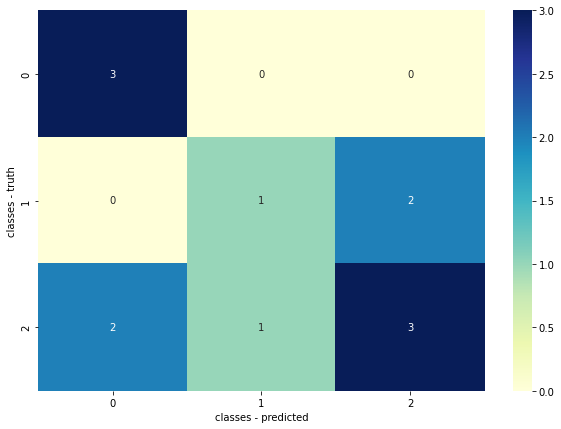

In [15]:
plt.figure(figsize=(10,7))
sns.heatmap(confu_test, annot=True, fmt='g',cmap = 'YlGnBu')
plt.xlabel('classes - predicted')
plt.ylabel('classes - truth')
plt.show()

14. Manipulate the arrays 'y_true' and 'y_pred' to increase the accuracy of class '1'. (hint: there are 2 possible things to do)

First option: increase the number of values for class 1. This also would mean that probably you will have to increase the number of values for class '2' to make it balanced

In [16]:
y_true = [2, 0, 2, 2, 0, 1, 0, 2, 1, 2, 2, 1, 1, 1]
y_pred = [0, 0, 2, 2, 0, 2, 0, 1, 2, 2, 0, 1, 1, 1]

Second option: keep the same number of values for the class '1' but match the number true with predicted data for this class. 

In [17]:
y_true = [2, 0, 2, 2, 0, 0, 0, 1, 0, 2, 2, 1]
y_pred = [0, 0, 2, 2, 0, 2, 0, 1, 2, 2, 0, 1]

15. Now we can run exactly the same analysis from exercise Nr.8, using a function in Python that summarizes all the previous calculations in one step. For this, we will use the same dataset, but change the labels of the landclasses to values:   
  FROM ["forest", "water", "soil"] TO [1, 2, 3,]

In [18]:
# define labels of rows and columns
index = [1, 2, 3, 'r_sum']
columns = [1, 2, 3, 'c_sum']
# fill in values
values = np.array([[758, 29, 18, 805],
                  [72, 746, 77, 895],
                  [384, 58, 356, 798],
                  [1214,833,451,2498]])

# turn the array into a pandas dataframe (table)
cm_df = pd.DataFrame(values, index=index)
cm_df.columns = columns
print(cm_df)

          1    2    3  c_sum
1       758   29   18    805
2        72  746   77    895
3       384   58  356    798
r_sum  1214  833  451   2498


<h4>Accuracy Assessment function on Python</h4>

In [19]:
# Let's configure the floating point precision of our output
np.set_printoptions(precision=2) # 2 decimals

# function for error estimations (AA)
def accAss(name, gcm, n_classes):
    #Completeness
    print('Accuracy Assessment for',name,'Prediction')
    comp = np.zeros(n_classes)
    for i in range(n_classes):
        comp[i]=gcm[i+1][i+1]/gcm[i+1]['r_sum']
    print('Producer Accuracy / Recall [%]:', (comp*100))
    
    #Correctness
    corr = np.zeros(n_classes)
    for i in range(n_classes):
        corr[i]=gcm[i+1][i+1]/gcm['c_sum'][i+1]
    print('User Accuracy / Precision [%]:',(corr*100))                         
    
    #Total Accuracy
    diag = np.zeros(n_classes)
    for i in range(n_classes):
        diag[i]=gcm[i+1][i+1]
    g = np.sum(diag)
    n = gcm['c_sum']['r_sum']
    ta = g/n
    print('Total Accuracy [%%]: %.2f' % (ta*100))
    
    #Correlation
    corr_v = np.zeros(n_classes)
    for i in range(n_classes):
        corr_v[i]=gcm[i+1]['r_sum']*gcm['c_sum'][i+1]
    K = np.sum(corr_v)
    
    #Cohen's Kappa
    k=(g*n-K)/((n*n)-K)
    print("Cohens's Kappa: %.2f" % k)

16. Apply this function on the same example of the lecture (exercise Nr.15), and compare with the results you calculated by hand (exercise Nr.8):

In [20]:
# apply function for AA on table 'cm_df', with 3 classes
accAss('Lecture Example',cm_df, 3)

Accuracy Assessment for Lecture Example Prediction
Producer Accuracy / Recall [%]: [62.44 89.56 78.94]
User Accuracy / Precision [%]: [94.16 83.35 44.61]
Total Accuracy [%]: 74.46
Cohens's Kappa: 0.62


<h3>D. Load raster and vector data</h3>

17. On this section you will load your raster and vector data and perform an accuracy assessment of your classification. The process of loading the data is exactly the same as for last week: classification. 

<h4>Load Sentinel2-A raster</h4>

18. Load the raster file that you want to. Adapt the code to your data.

In [21]:
# path to the classified image (Setinel-2A Rasterstack) 
s2_stack = os.path.join(folder_src, 'data/raster','S2_20220304_Cliped_Reflectance_RGBNIR.tif')

19. Extract the information of your raster data. Here, you make the attributes readable for the classification algorithm. Afterwards, the data is being transformed into a Numpy array for easier calculations.
Check the printing commands and the variables that are being used!

In [22]:
# load image data
#In this script we are Using gdal.open() instead of rio.open()
img_ds = gdal.Open(s2_stack, gdal.GA_ReadOnly)

img = np.zeros((img_ds.RasterYSize, img_ds.RasterXSize, img_ds.RasterCount),
               gdal_array.GDALTypeCodeToNumericTypeCode(img_ds.GetRasterBand(1).DataType))
for b in range(img.shape[2]):
    img[:, :, b] = img_ds.GetRasterBand(b + 1).ReadAsArray()

print("Raster format is:", gdal_array.GDALTypeCodeToNumericTypeCode(img_ds.GetRasterBand(1).DataType))
    
# store the variables above in a more meaningful way. You will use these variables later.
row = img_ds.RasterYSize
col = img_ds.RasterXSize
band_number = img_ds.RasterCount
# Values bigger when 1 will be set to 1
img[img>1] = 1

print("Raster number of rows: {}".format(row))
print("Raster number of columns: {}".format(col))
print("Raster number of bands: {}".format(band_number))

Raster format is: <class 'numpy.float32'>
Raster number of rows: 193
Raster number of columns: 250
Raster number of bands: 4


<h4>Load Minimum Distance and Random Forest classification rasters</h4>

20. Define individual paths for your classification rasters

In [23]:
# path to the classification rasters, depending of the algorithm used
#Random Forest
rf_pred_path = os.path.join(folder_results, 'rf_nt250.tif')
#Minimum Distance
knn_pred_path = os.path.join(folder_results, 'md_classi.tif')

21. Now we are going to load the prediction result rasters from the last practice and see if the dimensions are correct (they should match the extent of your Sentinel-2a image):

In [24]:
# Check dimensions of RF classification

# open file
rf_open = gdal.Open(rf_pred_path, gdal.GA_ReadOnly)
# extract metadata
rf_meta = np.zeros((rf_open.RasterYSize, rf_open.RasterXSize, rf_open.RasterCount), gdal_array.GDALTypeCodeToNumericTypeCode(rf_open.GetRasterBand(1).DataType))
for b in range(rf_meta.shape[2]):
    rf_meta[:, :, b] = rf_open.GetRasterBand(b + 1).ReadAsArray()
# define the new shape for the rf classification
new_shape = (rf_meta.shape[0], rf_meta.shape[1])
# reshape
rf_pred = rf_meta[:, :, :int(rf_meta.shape[2])].reshape(new_shape)

# compare the dimensions. They are the same as S2a
print("Dimensions of RF after 'reshape()' are",rf_pred.shape)

Dimensions of RF after 'reshape()' are (193, 250)


In [25]:
# Check dimensions of MD classification = prediction

# open file
knn_open = gdal.Open(knn_pred_path, gdal.GA_ReadOnly)
# extract metadata
knn_meta = np.zeros((knn_open.RasterYSize, knn_open.RasterXSize, knn_open.RasterCount), gdal_array.GDALTypeCodeToNumericTypeCode(knn_open.GetRasterBand(1).DataType))
for b in range(knn_meta.shape[2]):
    knn_meta[:, :, b] = knn_open.GetRasterBand(b + 1).ReadAsArray()
# define the new shape for the md classification
new_shapeknn = (knn_meta.shape[0], knn_meta.shape[1])
# reshape
knn_pred = knn_meta[:, :, :int(knn_meta.shape[2])].reshape(new_shapeknn)

# compare the dimensions. They are the same as S2a
print("Dimensions of MD after 'reshape()' are",knn_pred.shape)

Dimensions of MD after 'reshape()' are (193, 250)


<h4>Load validation shapefile</h4>

22. Load your validation data (shapefiles). Define the column that has the attributes (i.e. 'landclass' OR 'class' OR 'landcover').
Adapt the code to your data.

In [26]:
#validation as shape files
validation = os.path.join(folder_src,'data/vector','test_20220304.shp')

In [27]:
# what is the attributes name of your classes in the shape file (field name of the classes)?
attribute = 'class'

23. Recheck if the validation data is in the correct format:

In [28]:
# load validation data and show all shape attributes
shape_dataset = ogr.Open(validation)
shape_layer = shape_dataset.GetLayer()

# extract the names of all attributes (fieldnames) in the shape file
attributes = []
ldefn = shape_layer.GetLayerDefn()
for n in range(ldefn.GetFieldCount()):
    fdefn = ldefn.GetFieldDefn(n)
    attributes.append(fdefn.name)
    
# print the attributes
print('Available attributes in the shape file are: {}'.format(attributes))

AttributeError: 'NoneType' object has no attribute 'GetLayer'

24. Rasterize your validation polygons

In [ ]:
# load training data from shape file and rasterize

shape_dataset = ogr.Open(validation)
shape_layer = shape_dataset.GetLayer()

mem_drv = gdal.GetDriverByName('MEM')
mem_raster = mem_drv.Create('',img_ds.RasterXSize,img_ds.RasterYSize,1,gdal.GDT_UInt16)
mem_raster.SetProjection(img_ds.GetProjection())
mem_raster.SetGeoTransform(img_ds.GetGeoTransform())
mem_band = mem_raster.GetRasterBand(1)
mem_band.Fill(0)
mem_band.SetNoDataValue(0)

att_ = 'ATTRIBUTE='+attribute
# http://gdal.org/gdal__alg_8h.html#adfe5e5d287d6c184aab03acbfa567cb1
# http://gis.stackexchange.com/questions/31568/gdal-rasterizelayer-doesnt-burn-all-polygons-to-raster
err = gdal.RasterizeLayer(mem_raster, [1], shape_layer, None, None, [1],  [att_,"ALL_TOUCHED=TRUE"])
assert err == gdal.CE_None

val = mem_raster.ReadAsArray()

25. Voilà! Now you have your validation polygons in the same resolution and projection as your Sentinel-2 Rasterstack. The next task is to extract the validation pixels (OR 'samples') from the Rasterstack.
The samples will be used for measuring the accuracy of the classification raster. In total, I am extracting 1091 samples from the matrix 'X'.

In [ ]:
# Number of validation pixels:
n_samples = (val > 0).sum()
print('{n} validation samples'.format(n=n_samples))

# What are our classification labels?
labels = np.unique(val[val > 0])
print('validation data include {n} classes: {classes}'.format(n=labels.size, classes=labels))

# Subset the image dataset with the image = X
# Mask the classes on the validation dataset = y
# These will have n_samples rows
X_rf = rf_pred[val > 0]
y = val[val > 0]

print('Our X matrix is sized: {sz}'.format(sz=X_rf.shape))
print('Our y array is sized: {sz}'.format(sz=y.shape))

26. Why the dimensions of both X and y are the same? How many bands each object has? Compare this result with the step Nr.10 from Practice 5. 

The dimensions of X and y are the same, because X is being selected based on positived values for y (i.e. X_rf = rf_pred[val > 0]).   
Each object has only 1 band.  
In Practice Nr.5 we tried to select in this step the number of training samples. Here we are selecting the number of validation samples. 

27. What determines the number of samples from the polygons?

The size and number of the validation polygons

<h4>Visualization of data</h4>

28. Plot all your files: S2A rasterstack, validation polygons, classification rasters 

In [ ]:
# Define color palette
#"Water", "Ground", "Coniferous", "Deciduous", "Roof", "AgricultureAreaType1", "AgricultureAreaType2"
custom_cmap = ListedColormap(["lightseagreen","gray","darkgreen","lightgreen","red","yellow","green"])

In [ ]:
# Define the size of the graphs
#plot=plt.subplots(figsize=(20,20))
fig,ax = plt.subplots(figsize=(20,20))
# Define the spacing among graphs
fig.tight_layout(pad=4.0)

# Plot the rasterstack with an Adaptive Equalization
plt.subplot(221)
img_adapteq = exposure.equalize_adapthist(img, clip_limit=0.03)
plot_rs = plt.imshow(img_adapteq)
plt.title('Sentinel-2 RasterStack\n RGB, colors adjusted', fontsize=20)
## More info: https://scikit-image.org/docs/dev/auto_examples/color_exposure/plot_equalize.html

# Plot the blue band with the training polygons
plt.subplot(222)
plt.imshow(img[:, :, 0], cmap=plt.cm.Greys_r)
# Add your training polygons on top. NOTICE that you have here validation and not training polygons
plot_tr = plt.imshow(val, cmap='jet', alpha=0.5)
plt.title("Sentinel-2 blue band\n  with training polygons", fontsize=20)
                  
# Plot the RandomForest classification
plt.subplot(223)
plot_rf = plt.imshow(rf_pred, cmap=custom_cmap)
plt.title('Random Forest Classification\n n-trees = 250', fontsize=20)
## I eliminated here the colorbar, for visualization purposes

# Plot the Minimum Distance classification
plt.subplot(224)
plot_md = plt.imshow(knn_pred, cmap=custom_cmap)
plt.title('Minimum Distance Classification', fontsize=20)
## I eliminated here the colorbar, for visualization purposes

# show your plots. This command has to be run only once.
plt.show()



<h3>E. Accuracy Assessment: Estimate Confusion Matrix and Errors on your classification</h3>

29. Plot the confusion matrix of your Random Forest classification 

In [ ]:
# use the function 'confusion_matrix' from scikit-learn to plot the confusion matrix of your RF classification
cm_val = confusion_matrix(y, X_rf).T # invert rows and cols

# X_rf = prediction from rf
# X_md = prediction from md
# y = 'true pixel values' = reference dataset = validation shapefile

# define size of plot
plt.figure(figsize=(10,7))
# color the table. The higher the value, the darker the color
sns.heatmap(cm_val, annot=True, fmt='g',cmap = 'YlGnBu' )
# labels
plt.xlabel('Reference')
plt.ylabel('Classification')
# plot
plt.show()
# print text
print('Confusion matrix of Random Forest classification\n Landclasses:\n 0 = Water\n 1 = Ground\n 2 = Coniferous\n 3 = Deciduous\n 4 = Roof\n 5 = AgricultureAreaType1\n 6 = AgricultureAreaType2')

30. Drop your results in a pandas table

In [ ]:
# Compute a simple cross tabulation of two (or more) factors. By default computes a frequency table of the factors unless an array of values and an aggregation function are passed.
rcm = pd.crosstab(y, X_rf, margins=True).T # invert rows and cols


# rename the colums and rows of the table
rcm.rename(columns={'All':'c_sum'}, index={'All':'r_sum'}, inplace=True)
print(rcm)

31. Apply the Acuracy Assessment function on the confusion matrix of your Random Forest classification

In [ ]:
# apply function for AA on table 'rcm', with 7 classes
accAss('Random Forest',rcm, 7)

32. Verify 'by hand' that the errors estimation of the RF classification is correct

In [ ]:
OA = (315 + 339 + 199 + 63 + 232 + 506 + 593) / 2416
print('The Overall accuracy is {:.2f}%'.format(OA*100))

PA_Water = 315/315
PA_Ground = 339/342
PA_Coniferous = 199/207
PA_Deciduous = 63/92
PA_Roof = 232/351
PA_AgricultureAreaType1 = 506/510
PA_AgricultureAreaType2 = 593/599

UA_Water = 315/315
UA_Ground = 339/419
UA_Coniferous = 199/204
UA_Deciduous = 63/93
UA_Roof = 232/244
UA_AgricultureAreaType1 = 506/527
UA_AgricultureAreaType2 = 593/614

# Calculate Kappa

# First, calculate K (equation 6 in the lecture)
K = (315*315 + 342*419 + 207*204 + 92*93 + 351*244 + 510*527 + 599*614)
# Second, list all the other variables needed
g = 315 + 339 + 199 + 63 + 232 + 506 + 593 # correctly classified pixels
n = 2416 # sum of all pixels
n2 = pow(n, 2) # n to the power of 2
# Third, use all variables to calculate kappa (equation 7 in the lecture)
kappa = (g*n-K)/(n2 - K)

print('The Kappa coeficient is {:.2f}'.format(kappa))

33. Calculate the confusion matrix and estimate the errors of your Minimum Distance classification.

In [ ]:
# Subset the image dataset with the image = X
# Mask the classes on the validation dataset = y
# These will have n_samples rows
X_md = knn_pred[val > 0]
y = val[val > 0]

# use the function 'confusion_matrix' from scikit-learn to plot the confusion matrix of your RF classification
cm_val_md = confusion_matrix(y, X_md).T # invert rows and cols
print(cm_val_md)

In [ ]:
# Compute a simple cross tabulation of two (or more) factors. By default computes a frequency table of the factors unless an array of values and an aggregation function are passed.
md_cm = pd.crosstab(y, X_md, margins=True).T  # invert rows and cols

# rename the colums and rows of the table
md_cm.rename(columns={'All':'c_sum'}, index={'All':'r_sum'}, inplace=True)
print(md_cm)

In [ ]:
# apply function for AA on table 'rcm', with 7 classes
accAss('Minimum Distance',md_cm, 7) 

34. Plot the confusion matrix of your MD classification

In [ ]:
# define size of plot
plt.figure(figsize=(10,7))
# color the table. The higher the value, the darker the color
sns.heatmap(cm_val_md, annot=True, fmt='g',cmap = 'YlGnBu' )
# labels
plt.xlabel('Reference')
plt.ylabel('Classification')
# plot
plt.show()
# print text
print('Confusion matrix of Minimum Distance classification\n Landclasses:\n 0 = Water\n 1 = Ground\n 2 = Coniferous\n 3 = Deciduous\n 4 = Roof\n 5 = AgricultureAreaType1\n 6 = AgricultureAreaType2')

35. Is there any difference in the AA of every classification? What are the reasons for this? 

(discussed in the practice)

<div style="text-align: right"> <small>This tutorial was prepared with the support from Gabriel Cevallos (2020) and Marina Trinz (2023)</small> </div>